In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [10]:
import gym
import gym_market
import numpy as np
import imp

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


/Users/gkonstantellos/opt/miniconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [11]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1]
Rewards: [1.3, -1.42, -0.49, -4.470000000000001, -4.5200000000000005, 0.47000000000000003, -0.58, -0.6499999999999999, -1.69, -1.73, -1.77, -1.81, -1.8499999999999999, -3.6500000000000004, -4.7, -1.72, -1.7399999999999998, -0.71, 0.94, 0.8700000000000001, -0.16999999999999998]
Return: 1.0257910260684184


In [12]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [13]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [14]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [15]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [16]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.


Populate memory:

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -8.759999999999998 Training loss: 9.6532 Explore P: 0.9979 Total return: 0.92
Episode: 2 Total reward: -17.68 Training loss: 3.5248 Explore P: 0.9959 Total return: 1.14
Episode: 3 Total reward: -14.419999999999998 Training loss: 3.7933 Explore P: 0.9938 Total return: 0.96
Episode: 4 Total reward: -16.430000000000003 Training loss: 1.9194 Explore P: 0.9917 Total return: 1.07
Episode: 5 Total reward: -15.330000000000004 Training loss: 4.5906 Explore P: 0.9897 Total return: 1.04
Episode: 6 Total reward: -19.849999999999994 Training loss: 2.2986 Explore P: 0.9876 Total return: 0.97
Episode: 7 Total reward: -33.599999999999994 Training loss: 4.6834 Explore P: 0.9856 Total return: 0.95
Episode: 8 Total reward: -11.01 Training loss: 2.3797 Explore P: 0.9835 Total return: 1.00
Episode: 9 Total reward: -18.259999999999998 Training loss: 1.3730 Explore P: 0.9815 Total return: 0.83
Episode: 10 Total reward: -29.779999999999998 Training loss: 3.5942 Explore P: 0.9794 Total

Episode: 84 Total reward: -34.4 Training loss: 3.4853 Explore P: 0.8399 Total return: 0.89
Episode: 85 Total reward: -17.449999999999996 Training loss: 4.9916 Explore P: 0.8382 Total return: 1.01
Episode: 86 Total reward: -33.089999999999996 Training loss: 4.4060 Explore P: 0.8364 Total return: 0.87
Episode: 87 Total reward: -4.239999999999999 Training loss: 4.0347 Explore P: 0.8347 Total return: 1.11
Episode: 88 Total reward: -38.15 Training loss: 3.6162 Explore P: 0.8330 Total return: 0.93
Episode: 89 Total reward: -22.7 Training loss: 4.2929 Explore P: 0.8312 Total return: 0.86
Episode: 90 Total reward: -8.389999999999995 Training loss: 3.4898 Explore P: 0.8295 Total return: 0.98
Episode: 91 Total reward: -11.83 Training loss: 1.6830 Explore P: 0.8278 Total return: 0.92
Episode: 92 Total reward: -27.299999999999997 Training loss: 4.3694 Explore P: 0.8261 Total return: 0.90
Episode: 93 Total reward: -9.510000000000002 Training loss: 2.5079 Explore P: 0.8244 Total return: 1.15
Episode

Episode: 168 Total reward: -5.3599999999999985 Training loss: 3.9155 Explore P: 0.7057 Total return: 1.09
Episode: 169 Total reward: -37.56 Training loss: 2.8491 Explore P: 0.7042 Total return: 0.83
Episode: 170 Total reward: -27.439999999999994 Training loss: 4.7990 Explore P: 0.7028 Total return: 0.87
Episode: 171 Total reward: -17.62 Training loss: 2.9930 Explore P: 0.7013 Total return: 0.98
Episode: 172 Total reward: -46.21999999999999 Training loss: 3.0431 Explore P: 0.6999 Total return: 0.96
Episode: 173 Total reward: -39.78 Training loss: 2.6498 Explore P: 0.6984 Total return: 0.90
Episode: 174 Total reward: -32.849999999999994 Training loss: 3.0130 Explore P: 0.6970 Total return: 1.23
Episode: 175 Total reward: -14.9 Training loss: 2.5565 Explore P: 0.6955 Total return: 1.02
Episode: 176 Total reward: -31.0 Training loss: 3.6332 Explore P: 0.6941 Total return: 1.06
Episode: 177 Total reward: -16.439999999999998 Training loss: 1.6997 Explore P: 0.6927 Total return: 1.03
Episode:

Episode: 253 Total reward: -50.64000000000001 Training loss: 2.8590 Explore P: 0.5920 Total return: 0.77
Episode: 254 Total reward: -11.45 Training loss: 3.1807 Explore P: 0.5907 Total return: 1.10
Episode: 255 Total reward: -12.459999999999999 Training loss: 3.9206 Explore P: 0.5895 Total return: 1.06
Episode: 256 Total reward: -36.949999999999996 Training loss: 1.4273 Explore P: 0.5883 Total return: 0.88
Episode: 257 Total reward: -17.55 Training loss: 2.8677 Explore P: 0.5871 Total return: 0.99
Episode: 258 Total reward: -1.1699999999999995 Training loss: 1.1308 Explore P: 0.5859 Total return: 0.97
Episode: 259 Total reward: -6.799999999999997 Training loss: 4.7291 Explore P: 0.5847 Total return: 1.06
Episode: 260 Total reward: -8.95 Training loss: 4.6011 Explore P: 0.5835 Total return: 1.02
Episode: 261 Total reward: -34.31 Training loss: 3.7684 Explore P: 0.5823 Total return: 0.91
Episode: 262 Total reward: -34.480000000000004 Training loss: 3.2211 Explore P: 0.5811 Total return: 

Episode: 336 Total reward: -6.74 Training loss: 1.9622 Explore P: 0.4989 Total return: 1.03
Episode: 337 Total reward: -5.059999999999999 Training loss: 3.2020 Explore P: 0.4978 Total return: 1.09
Episode: 338 Total reward: -8.43 Training loss: 3.4729 Explore P: 0.4968 Total return: 1.01
Episode: 339 Total reward: -9.68 Training loss: 4.6669 Explore P: 0.4958 Total return: 1.09
Episode: 340 Total reward: -41.21000000000001 Training loss: 2.2837 Explore P: 0.4948 Total return: 1.05
Episode: 341 Total reward: -20.270000000000003 Training loss: 4.3385 Explore P: 0.4938 Total return: 0.92
Episode: 342 Total reward: -11.81 Training loss: 3.2256 Explore P: 0.4928 Total return: 0.93
Episode: 343 Total reward: -14.569999999999997 Training loss: 4.2929 Explore P: 0.4917 Total return: 1.00
Episode: 344 Total reward: -15.620000000000001 Training loss: 3.7877 Explore P: 0.4907 Total return: 0.97
Episode: 345 Total reward: -37.81999999999999 Training loss: 2.9598 Explore P: 0.4897 Total return: 0.9

Episode: 420 Total reward: -40.16 Training loss: 2.7330 Explore P: 0.4198 Total return: 0.94
Episode: 421 Total reward: -29.54 Training loss: 4.1100 Explore P: 0.4190 Total return: 0.96
Episode: 422 Total reward: -15.65 Training loss: 1.7447 Explore P: 0.4181 Total return: 0.89
Episode: 423 Total reward: -11.360000000000003 Training loss: 2.2412 Explore P: 0.4172 Total return: 1.03
Episode: 424 Total reward: -17.750000000000004 Training loss: 2.8247 Explore P: 0.4164 Total return: 0.98
Episode: 425 Total reward: -19.5 Training loss: 3.6024 Explore P: 0.4155 Total return: 1.11
Episode: 426 Total reward: -36.31 Training loss: 3.7351 Explore P: 0.4147 Total return: 0.93
Episode: 427 Total reward: -31.670000000000005 Training loss: 2.5767 Explore P: 0.4138 Total return: 0.94
Episode: 428 Total reward: -26.94 Training loss: 4.1180 Explore P: 0.4130 Total return: 0.98
Episode: 429 Total reward: -51.64000000000001 Training loss: 1.6194 Explore P: 0.4121 Total return: 0.87
Episode: 430 Total r

Episode: 504 Total reward: -12.39 Training loss: 4.0037 Explore P: 0.3535 Total return: 1.02
Episode: 505 Total reward: -18.75 Training loss: 3.8396 Explore P: 0.3528 Total return: 0.98
Episode: 506 Total reward: -17.12 Training loss: 4.3785 Explore P: 0.3521 Total return: 0.87
Episode: 507 Total reward: -23.86 Training loss: 3.2763 Explore P: 0.3514 Total return: 1.00
Episode: 508 Total reward: -22.249999999999996 Training loss: 3.3341 Explore P: 0.3507 Total return: 0.97
Episode: 509 Total reward: -16.630000000000003 Training loss: 2.7634 Explore P: 0.3500 Total return: 0.95
Episode: 510 Total reward: -12.870000000000001 Training loss: 3.4109 Explore P: 0.3492 Total return: 1.10
Episode: 511 Total reward: -1.0499999999999994 Training loss: 1.4924 Explore P: 0.3485 Total return: 1.09
Episode: 512 Total reward: -10.11 Training loss: 3.5730 Explore P: 0.3478 Total return: 0.93
Episode: 513 Total reward: -13.459999999999997 Training loss: 3.0376 Explore P: 0.3471 Total return: 1.02
Episo

Episode: 587 Total reward: -40.11 Training loss: 4.0480 Explore P: 0.2986 Total return: 0.97
Episode: 588 Total reward: -3.83 Training loss: 3.7663 Explore P: 0.2980 Total return: 1.02
Episode: 589 Total reward: -41.97 Training loss: 2.2149 Explore P: 0.2974 Total return: 0.83
Episode: 590 Total reward: -26.470000000000006 Training loss: 2.6535 Explore P: 0.2968 Total return: 1.01
Episode: 591 Total reward: -56.699999999999996 Training loss: 2.4564 Explore P: 0.2962 Total return: 0.89
Episode: 592 Total reward: -7.0299999999999985 Training loss: 2.8900 Explore P: 0.2956 Total return: 0.99
Episode: 593 Total reward: -41.16 Training loss: 4.0512 Explore P: 0.2950 Total return: 0.94
Episode: 594 Total reward: -26.339999999999996 Training loss: 2.5115 Explore P: 0.2944 Total return: 0.94
Episode: 595 Total reward: -2.1599999999999993 Training loss: 2.4590 Explore P: 0.2938 Total return: 1.10
Episode: 596 Total reward: -5.699999999999999 Training loss: 4.7397 Explore P: 0.2932 Total return:

Episode: 670 Total reward: -41.00000000000001 Training loss: 3.5751 Explore P: 0.2524 Total return: 0.93
Episode: 671 Total reward: -44.9 Training loss: 2.7764 Explore P: 0.2519 Total return: 0.85
Episode: 672 Total reward: -14.660000000000002 Training loss: 1.8824 Explore P: 0.2514 Total return: 1.08
Episode: 673 Total reward: -16.8 Training loss: 2.2347 Explore P: 0.2509 Total return: 0.96
Episode: 674 Total reward: -43.33 Training loss: 2.3697 Explore P: 0.2504 Total return: 0.94
Episode: 675 Total reward: -42.70000000000001 Training loss: 2.5480 Explore P: 0.2499 Total return: 0.93
Episode: 676 Total reward: -30.820000000000004 Training loss: 3.6793 Explore P: 0.2494 Total return: 0.93
Episode: 677 Total reward: -32.83 Training loss: 3.6110 Explore P: 0.2489 Total return: 0.95
Episode: 678 Total reward: -49.73 Training loss: 3.3293 Explore P: 0.2484 Total return: 0.89
Episode: 679 Total reward: -32.14 Training loss: 2.0108 Explore P: 0.2479 Total return: 1.00
Episode: 680 Total rew

Episode: 753 Total reward: -24.080000000000002 Training loss: 3.5888 Explore P: 0.2137 Total return: 1.00
Episode: 754 Total reward: -25.749999999999996 Training loss: 2.4494 Explore P: 0.2132 Total return: 1.02
Episode: 755 Total reward: -21.71 Training loss: 1.2642 Explore P: 0.2128 Total return: 0.94
Episode: 756 Total reward: -32.4 Training loss: 2.6592 Explore P: 0.2124 Total return: 1.01
Episode: 757 Total reward: -15.369999999999997 Training loss: 4.6145 Explore P: 0.2119 Total return: 0.97
Episode: 758 Total reward: -25.700000000000003 Training loss: 1.9087 Explore P: 0.2115 Total return: 1.11
Episode: 759 Total reward: -28.040000000000003 Training loss: 2.4296 Explore P: 0.2111 Total return: 1.02
Episode: 760 Total reward: -10.819999999999999 Training loss: 3.5020 Explore P: 0.2107 Total return: 1.10
Episode: 761 Total reward: -17.06 Training loss: 2.4126 Explore P: 0.2103 Total return: 0.99
Episode: 762 Total reward: -10.71 Training loss: 3.0399 Explore P: 0.2098 Total return

Episode: 838 Total reward: -18.82 Training loss: 1.5271 Explore P: 0.1804 Total return: 1.06
Episode: 839 Total reward: -12.91 Training loss: 2.5309 Explore P: 0.1800 Total return: 1.04
Episode: 840 Total reward: -57.9 Training loss: 1.8673 Explore P: 0.1796 Total return: 1.00
Episode: 841 Total reward: -14.81 Training loss: 1.6595 Explore P: 0.1793 Total return: 1.11
Episode: 842 Total reward: -34.099999999999994 Training loss: 1.4403 Explore P: 0.1789 Total return: 1.00
Episode: 843 Total reward: -34.81 Training loss: 1.3788 Explore P: 0.1786 Total return: 0.96
Episode: 844 Total reward: -40.430000000000014 Training loss: 2.4033 Explore P: 0.1782 Total return: 0.88
Episode: 845 Total reward: -40.120000000000005 Training loss: 3.2333 Explore P: 0.1779 Total return: 0.87
Episode: 846 Total reward: -7.160000000000002 Training loss: 3.5715 Explore P: 0.1775 Total return: 1.04
Episode: 847 Total reward: -8.59 Training loss: 1.4332 Explore P: 0.1772 Total return: 0.96
Episode: 848 Total re

Episode: 922 Total reward: -31.61 Training loss: 2.6959 Explore P: 0.1528 Total return: 1.05
Episode: 923 Total reward: -33.150000000000006 Training loss: 2.8611 Explore P: 0.1525 Total return: 0.91
Episode: 924 Total reward: -1.2099999999999995 Training loss: 3.6805 Explore P: 0.1522 Total return: 1.03
Episode: 925 Total reward: -48.550000000000004 Training loss: 1.7520 Explore P: 0.1519 Total return: 0.97
Episode: 926 Total reward: -9.760000000000002 Training loss: 2.2050 Explore P: 0.1516 Total return: 1.03
Episode: 927 Total reward: -35.56999999999999 Training loss: 4.5757 Explore P: 0.1513 Total return: 1.02
Episode: 928 Total reward: -2.659999999999999 Training loss: 2.0030 Explore P: 0.1510 Total return: 1.01
Episode: 929 Total reward: -39.78 Training loss: 1.8135 Explore P: 0.1507 Total return: 0.91
Episode: 930 Total reward: -40.03 Training loss: 2.0819 Explore P: 0.1504 Total return: 0.84
Episode: 931 Total reward: -15.91 Training loss: 2.1934 Explore P: 0.1501 Total return: 

Episode: 1006 Total reward: -28.22 Training loss: 2.5621 Explore P: 0.1297 Total return: 0.94
Episode: 1007 Total reward: 0.12000000000000105 Training loss: 1.4760 Explore P: 0.1295 Total return: 1.12
Episode: 1008 Total reward: -25.449999999999996 Training loss: 2.5290 Explore P: 0.1292 Total return: 1.03
Episode: 1009 Total reward: -30.750000000000004 Training loss: 2.7973 Explore P: 0.1290 Total return: 0.98
Episode: 1010 Total reward: -39.0 Training loss: 2.9678 Explore P: 0.1287 Total return: 0.93
Episode: 1011 Total reward: -23.3 Training loss: 2.8592 Explore P: 0.1285 Total return: 0.95
Episode: 1012 Total reward: -29.21 Training loss: 2.7729 Explore P: 0.1282 Total return: 1.01
Episode: 1013 Total reward: -31.619999999999994 Training loss: 2.3470 Explore P: 0.1280 Total return: 0.99
Episode: 1014 Total reward: -28.0 Training loss: 3.3411 Explore P: 0.1277 Total return: 1.05
Episode: 1015 Total reward: -19.97 Training loss: 3.6627 Explore P: 0.1275 Total return: 1.03
Episode: 10

Episode: 1088 Total reward: -37.029999999999994 Training loss: 3.0771 Explore P: 0.1108 Total return: 0.97
Episode: 1089 Total reward: -48.1 Training loss: 1.7545 Explore P: 0.1106 Total return: 0.81
Episode: 1090 Total reward: -52.75000000000001 Training loss: 2.3689 Explore P: 0.1104 Total return: 0.94
Episode: 1091 Total reward: -9.92 Training loss: 1.8963 Explore P: 0.1101 Total return: 1.07
Episode: 1092 Total reward: -23.47 Training loss: 3.9245 Explore P: 0.1099 Total return: 1.01
Episode: 1093 Total reward: -34.34999999999999 Training loss: 2.6386 Explore P: 0.1097 Total return: 1.04
Episode: 1094 Total reward: -16.849999999999998 Training loss: 2.1788 Explore P: 0.1095 Total return: 1.00
Episode: 1095 Total reward: -37.05 Training loss: 2.3737 Explore P: 0.1093 Total return: 1.01
Episode: 1096 Total reward: -15.35 Training loss: 1.8279 Explore P: 0.1091 Total return: 1.02
Episode: 1097 Total reward: -11.439999999999996 Training loss: 3.7125 Explore P: 0.1089 Total return: 1.06

Episode: 1171 Total reward: -47.449999999999996 Training loss: 4.1631 Explore P: 0.0947 Total return: 0.88
Episode: 1172 Total reward: -24.370000000000005 Training loss: 3.7312 Explore P: 0.0945 Total return: 1.02
Episode: 1173 Total reward: -40.330000000000005 Training loss: 2.2292 Explore P: 0.0943 Total return: 0.95
Episode: 1174 Total reward: -19.240000000000002 Training loss: 3.1123 Explore P: 0.0941 Total return: 1.06
Episode: 1175 Total reward: -52.8 Training loss: 3.6643 Explore P: 0.0939 Total return: 1.00
Episode: 1176 Total reward: -26.430000000000003 Training loss: 1.9383 Explore P: 0.0938 Total return: 0.95
Episode: 1177 Total reward: -36.65 Training loss: 3.2084 Explore P: 0.0936 Total return: 1.04
Episode: 1178 Total reward: -43.65 Training loss: 3.6971 Explore P: 0.0934 Total return: 0.95
Episode: 1179 Total reward: -39.17 Training loss: 3.6362 Explore P: 0.0932 Total return: 0.94
Episode: 1180 Total reward: -5.009999999999999 Training loss: 3.4816 Explore P: 0.0931 Tot

Episode: 1255 Total reward: -56.199999999999996 Training loss: 2.0771 Explore P: 0.0810 Total return: 1.00
Episode: 1256 Total reward: -31.129999999999995 Training loss: 2.2036 Explore P: 0.0808 Total return: 0.76
Episode: 1257 Total reward: -11.71 Training loss: 5.7139 Explore P: 0.0807 Total return: 1.07
Episode: 1258 Total reward: 1.32 Training loss: 2.7161 Explore P: 0.0805 Total return: 1.11
Episode: 1259 Total reward: -11.019999999999998 Training loss: 2.3748 Explore P: 0.0804 Total return: 1.08
Episode: 1260 Total reward: -54.28000000000001 Training loss: 2.6111 Explore P: 0.0802 Total return: 0.86
Episode: 1261 Total reward: -17.61 Training loss: 2.3543 Explore P: 0.0801 Total return: 1.05
Episode: 1262 Total reward: -14.94 Training loss: 1.8504 Explore P: 0.0799 Total return: 1.04
Episode: 1263 Total reward: -5.389999999999999 Training loss: 1.3743 Explore P: 0.0798 Total return: 1.11
Episode: 1264 Total reward: -16.13 Training loss: 2.4781 Explore P: 0.0796 Total return: 0.97

Episode: 1339 Total reward: -2.4299999999999997 Training loss: 3.2957 Explore P: 0.0695 Total return: 1.06
Episode: 1340 Total reward: -30.700000000000003 Training loss: 2.5047 Explore P: 0.0694 Total return: 1.00
Episode: 1341 Total reward: -25.08 Training loss: 4.1182 Explore P: 0.0692 Total return: 1.01
Episode: 1342 Total reward: -5.930000000000001 Training loss: 2.5723 Explore P: 0.0691 Total return: 1.00
Episode: 1343 Total reward: -22.709999999999997 Training loss: 2.8590 Explore P: 0.0690 Total return: 1.02
Episode: 1344 Total reward: -5.839999999999998 Training loss: 2.4996 Explore P: 0.0689 Total return: 1.07
Episode: 1345 Total reward: -16.4 Training loss: 3.9915 Explore P: 0.0687 Total return: 0.92
Episode: 1346 Total reward: -28.33 Training loss: 1.7355 Explore P: 0.0686 Total return: 0.90
Episode: 1347 Total reward: -7.639999999999995 Training loss: 3.2847 Explore P: 0.0685 Total return: 0.99
Episode: 1348 Total reward: -32.85 Training loss: 2.1997 Explore P: 0.0684 Total

Episode: 1420 Total reward: -3.039999999999999 Training loss: 2.8668 Explore P: 0.0602 Total return: 1.09
Episode: 1421 Total reward: -19.970000000000002 Training loss: 2.4472 Explore P: 0.0601 Total return: 1.01
Episode: 1422 Total reward: -8.290000000000001 Training loss: 2.0591 Explore P: 0.0600 Total return: 1.04
Episode: 1423 Total reward: 1.1000000000000008 Training loss: 2.4611 Explore P: 0.0599 Total return: 1.11
Episode: 1424 Total reward: -16.62 Training loss: 1.9595 Explore P: 0.0598 Total return: 1.11
Episode: 1425 Total reward: -15.21 Training loss: 2.9544 Explore P: 0.0597 Total return: 1.01
Episode: 1426 Total reward: -28.04 Training loss: 2.9377 Explore P: 0.0596 Total return: 0.98
Episode: 1427 Total reward: -30.380000000000003 Training loss: 3.2475 Explore P: 0.0595 Total return: 0.99
Episode: 1428 Total reward: -21.310000000000002 Training loss: 2.3199 Explore P: 0.0593 Total return: 0.96
Episode: 1429 Total reward: -32.58 Training loss: 2.0205 Explore P: 0.0592 Tota

Episode: 1502 Total reward: -35.06999999999999 Training loss: 2.6292 Explore P: 0.0522 Total return: 0.94
Episode: 1503 Total reward: -2.769999999999999 Training loss: 3.1757 Explore P: 0.0522 Total return: 1.12
Episode: 1504 Total reward: -5.479999999999999 Training loss: 2.1809 Explore P: 0.0521 Total return: 1.12
Episode: 1505 Total reward: -52.67 Training loss: 2.6190 Explore P: 0.0520 Total return: 0.59
Episode: 1506 Total reward: -2.9800000000000004 Training loss: 3.5193 Explore P: 0.0519 Total return: 1.08
Episode: 1507 Total reward: -34.72 Training loss: 2.8340 Explore P: 0.0518 Total return: 0.97
Episode: 1508 Total reward: 0.9400000000000007 Training loss: 2.5096 Explore P: 0.0517 Total return: 1.17
Episode: 1509 Total reward: -5.090000000000001 Training loss: 2.2859 Explore P: 0.0516 Total return: 1.08
Episode: 1510 Total reward: -9.010000000000002 Training loss: 2.8220 Explore P: 0.0515 Total return: 1.07
Episode: 1511 Total reward: -26.189999999999998 Training loss: 2.9654

Episode: 1583 Total reward: -14.650000000000002 Training loss: 2.9348 Explore P: 0.0456 Total return: 1.04
Episode: 1584 Total reward: -37.32000000000001 Training loss: 2.6590 Explore P: 0.0456 Total return: 0.92
Episode: 1585 Total reward: -34.970000000000006 Training loss: 2.2776 Explore P: 0.0455 Total return: 0.86
Episode: 1586 Total reward: -1.3499999999999996 Training loss: 2.5781 Explore P: 0.0454 Total return: 1.06
Episode: 1587 Total reward: -2.21 Training loss: 1.6219 Explore P: 0.0453 Total return: 1.06
Episode: 1588 Total reward: -2.9800000000000004 Training loss: 4.0545 Explore P: 0.0453 Total return: 1.03
Episode: 1589 Total reward: -1.0899999999999999 Training loss: 2.6791 Explore P: 0.0452 Total return: 1.10
Episode: 1590 Total reward: -36.95 Training loss: 3.5679 Explore P: 0.0451 Total return: 0.97
Episode: 1591 Total reward: -19.51 Training loss: 2.0192 Explore P: 0.0450 Total return: 0.94
Episode: 1592 Total reward: -44.27999999999999 Training loss: 2.4735 Explore P

Episode: 1664 Total reward: -3.2099999999999995 Training loss: 2.9919 Explore P: 0.0401 Total return: 1.04
Episode: 1665 Total reward: -33.2 Training loss: 3.6344 Explore P: 0.0400 Total return: 0.93
Episode: 1666 Total reward: 1.260000000000001 Training loss: 1.8336 Explore P: 0.0399 Total return: 1.11
Episode: 1667 Total reward: -0.2899999999999997 Training loss: 3.2811 Explore P: 0.0399 Total return: 1.12
Episode: 1668 Total reward: -0.06999999999999973 Training loss: 1.5420 Explore P: 0.0398 Total return: 1.05
Episode: 1669 Total reward: -51.82 Training loss: 3.9099 Explore P: 0.0397 Total return: 0.51
Episode: 1670 Total reward: -12.229999999999997 Training loss: 2.6795 Explore P: 0.0397 Total return: 1.02
Episode: 1671 Total reward: 0.2300000000000002 Training loss: 2.5252 Explore P: 0.0396 Total return: 1.05
Episode: 1672 Total reward: -7.499999999999999 Training loss: 2.1759 Explore P: 0.0396 Total return: 1.03
Episode: 1673 Total reward: -11.900000000000002 Training loss: 2.11

Episode: 1745 Total reward: -12.969999999999997 Training loss: 2.0631 Explore P: 0.0354 Total return: 1.06
Episode: 1746 Total reward: -18.099999999999998 Training loss: 2.3882 Explore P: 0.0353 Total return: 1.06
Episode: 1747 Total reward: -16.04 Training loss: 4.0121 Explore P: 0.0353 Total return: 1.03
Episode: 1748 Total reward: -22.97 Training loss: 3.1124 Explore P: 0.0352 Total return: 0.98
Episode: 1749 Total reward: -24.669999999999995 Training loss: 2.4904 Explore P: 0.0351 Total return: 0.97
Episode: 1750 Total reward: -16.669999999999998 Training loss: 2.3010 Explore P: 0.0351 Total return: 1.04
Episode: 1751 Total reward: -24.910000000000004 Training loss: 2.4680 Explore P: 0.0350 Total return: 1.05
Episode: 1752 Total reward: -12.08 Training loss: 1.6680 Explore P: 0.0350 Total return: 0.98
Episode: 1753 Total reward: -22.200000000000003 Training loss: 2.9049 Explore P: 0.0349 Total return: 0.98
Episode: 1754 Total reward: -2.3599999999999994 Training loss: 3.6708 Explor

Episode: 1826 Total reward: -26.68 Training loss: 2.4874 Explore P: 0.0314 Total return: 0.98
Episode: 1827 Total reward: 0.870000000000001 Training loss: 2.2859 Explore P: 0.0313 Total return: 1.08
Episode: 1828 Total reward: -15.170000000000002 Training loss: 2.5978 Explore P: 0.0313 Total return: 1.02
Episode: 1829 Total reward: -27.25 Training loss: 3.3950 Explore P: 0.0313 Total return: 0.98
Episode: 1830 Total reward: -27.079999999999995 Training loss: 2.1274 Explore P: 0.0312 Total return: 0.92
Episode: 1831 Total reward: -22.020000000000003 Training loss: 1.1215 Explore P: 0.0312 Total return: 1.05
Episode: 1832 Total reward: -15.1 Training loss: 1.7279 Explore P: 0.0311 Total return: 1.06
Episode: 1833 Total reward: -13.459999999999999 Training loss: 2.5325 Explore P: 0.0311 Total return: 1.00
Episode: 1834 Total reward: -24.329999999999995 Training loss: 1.9883 Explore P: 0.0310 Total return: 0.98
Episode: 1835 Total reward: -27.31 Training loss: 1.2998 Explore P: 0.0310 Tota

Episode: 1909 Total reward: -31.060000000000002 Training loss: 2.2603 Explore P: 0.0280 Total return: 0.95
Episode: 1910 Total reward: -30.939999999999994 Training loss: 1.8871 Explore P: 0.0279 Total return: 0.97
Episode: 1911 Total reward: -18.759999999999998 Training loss: 3.5986 Explore P: 0.0279 Total return: 1.00
Episode: 1912 Total reward: -9.84 Training loss: 4.4343 Explore P: 0.0279 Total return: 1.06
Episode: 1913 Total reward: -2.92 Training loss: 2.0749 Explore P: 0.0278 Total return: 1.01
Episode: 1914 Total reward: 0.9400000000000008 Training loss: 3.1213 Explore P: 0.0278 Total return: 1.10
Episode: 1915 Total reward: -26.350000000000005 Training loss: 2.3107 Explore P: 0.0277 Total return: 0.96
Episode: 1916 Total reward: -15.17 Training loss: 1.7786 Explore P: 0.0277 Total return: 1.00
Episode: 1917 Total reward: -36.88 Training loss: 2.0583 Explore P: 0.0277 Total return: 0.92
Episode: 1918 Total reward: -18.0 Training loss: 1.8261 Explore P: 0.0276 Total return: 1.05

Episode: 1993 Total reward: -4.41 Training loss: 3.2530 Explore P: 0.0251 Total return: 1.06
Episode: 1994 Total reward: -15.810000000000002 Training loss: 2.2990 Explore P: 0.0250 Total return: 0.97
Episode: 1995 Total reward: -34.52 Training loss: 1.2606 Explore P: 0.0250 Total return: 0.94
Episode: 1996 Total reward: -13.02 Training loss: 3.4757 Explore P: 0.0250 Total return: 1.08
Episode: 1997 Total reward: -32.769999999999996 Training loss: 2.1623 Explore P: 0.0249 Total return: 0.94
Episode: 1998 Total reward: -22.22 Training loss: 2.1294 Explore P: 0.0249 Total return: 0.99
Episode: 1999 Total reward: -25.770000000000003 Training loss: 2.2513 Explore P: 0.0249 Total return: 0.99
Episode: 2000 Total reward: -32.059999999999995 Training loss: 1.3849 Explore P: 0.0248 Total return: 0.70
Episode: 2001 Total reward: -32.47 Training loss: 3.0476 Explore P: 0.0248 Total return: 0.94
Episode: 2002 Total reward: -19.36 Training loss: 1.9350 Explore P: 0.0248 Total return: 1.02
Episode: 

Episode: 2077 Total reward: -29.939999999999998 Training loss: 2.1399 Explore P: 0.0226 Total return: 0.92
Episode: 2078 Total reward: -36.07999999999999 Training loss: 1.5127 Explore P: 0.0226 Total return: 0.97
Episode: 2079 Total reward: -13.2 Training loss: 1.6837 Explore P: 0.0226 Total return: 1.01
Episode: 2080 Total reward: -15.779999999999998 Training loss: 2.1848 Explore P: 0.0225 Total return: 1.00
Episode: 2081 Total reward: -40.79 Training loss: 2.0140 Explore P: 0.0225 Total return: 0.98
Episode: 2082 Total reward: -24.45 Training loss: 2.7445 Explore P: 0.0225 Total return: 0.99
Episode: 2083 Total reward: -30.580000000000002 Training loss: 2.4893 Explore P: 0.0225 Total return: 0.93
Episode: 2084 Total reward: -13.209999999999999 Training loss: 2.2391 Explore P: 0.0224 Total return: 1.02
Episode: 2085 Total reward: -42.33 Training loss: 2.1417 Explore P: 0.0224 Total return: 0.90
Episode: 2086 Total reward: -14.08 Training loss: 2.2298 Explore P: 0.0224 Total return: 0.

Episode: 2159 Total reward: -25.73 Training loss: 1.4607 Explore P: 0.0206 Total return: 1.00
Episode: 2160 Total reward: -30.24 Training loss: 2.1989 Explore P: 0.0206 Total return: 0.96
Episode: 2161 Total reward: -37.43000000000001 Training loss: 1.6245 Explore P: 0.0206 Total return: 0.96
Episode: 2162 Total reward: -5.75 Training loss: 2.4955 Explore P: 0.0206 Total return: 0.97
Episode: 2163 Total reward: -17.6 Training loss: 1.1140 Explore P: 0.0205 Total return: 0.98
Episode: 2164 Total reward: -28.82 Training loss: 1.4664 Explore P: 0.0205 Total return: 1.00
Episode: 2165 Total reward: -53.84 Training loss: 1.8616 Explore P: 0.0205 Total return: 0.77
Episode: 2166 Total reward: -49.98999999999999 Training loss: 1.6697 Explore P: 0.0205 Total return: 0.94
Episode: 2167 Total reward: 0.4700000000000002 Training loss: 2.8872 Explore P: 0.0205 Total return: 1.04
Episode: 2168 Total reward: -33.17 Training loss: 1.5816 Explore P: 0.0204 Total return: 1.00
Episode: 2169 Total reward

Episode: 2242 Total reward: -23.669999999999995 Training loss: 2.3070 Explore P: 0.0189 Total return: 1.01
Episode: 2243 Total reward: -9.139999999999999 Training loss: 1.8678 Explore P: 0.0189 Total return: 1.02
Episode: 2244 Total reward: -19.369999999999997 Training loss: 3.7845 Explore P: 0.0189 Total return: 0.99
Episode: 2245 Total reward: -40.33999999999999 Training loss: 2.5332 Explore P: 0.0189 Total return: 0.71
Episode: 2246 Total reward: -17.959999999999997 Training loss: 1.6451 Explore P: 0.0189 Total return: 1.00
Episode: 2247 Total reward: -3.619999999999999 Training loss: 4.1503 Explore P: 0.0188 Total return: 0.96
Episode: 2248 Total reward: -32.29 Training loss: 2.6726 Explore P: 0.0188 Total return: 0.94
Episode: 2249 Total reward: -16.539999999999996 Training loss: 2.8154 Explore P: 0.0188 Total return: 0.97
Episode: 2250 Total reward: -29.990000000000006 Training loss: 1.7448 Explore P: 0.0188 Total return: 1.00
Episode: 2251 Total reward: -26.75 Training loss: 2.0

Episode: 2324 Total reward: -17.080000000000002 Training loss: 2.2535 Explore P: 0.0175 Total return: 1.02
Episode: 2325 Total reward: -21.37 Training loss: 1.5876 Explore P: 0.0175 Total return: 1.05
Episode: 2326 Total reward: -34.44999999999999 Training loss: 1.8973 Explore P: 0.0175 Total return: 0.88
Episode: 2327 Total reward: -3.5699999999999994 Training loss: 1.1072 Explore P: 0.0175 Total return: 1.01
Episode: 2328 Total reward: -13.48 Training loss: 2.8351 Explore P: 0.0175 Total return: 1.09
Episode: 2329 Total reward: -29.31 Training loss: 2.1159 Explore P: 0.0174 Total return: 0.99
Episode: 2330 Total reward: 3.72 Training loss: 3.3217 Explore P: 0.0174 Total return: 1.09
Episode: 2331 Total reward: -2.2699999999999987 Training loss: 1.6586 Explore P: 0.0174 Total return: 1.10
Episode: 2332 Total reward: -14.040000000000003 Training loss: 1.9055 Explore P: 0.0174 Total return: 1.00
Episode: 2333 Total reward: -10.520000000000001 Training loss: 4.1776 Explore P: 0.0174 Tota

Episode: 2407 Total reward: -37.68000000000001 Training loss: 2.9747 Explore P: 0.0163 Total return: 0.99
Episode: 2408 Total reward: -2.62 Training loss: 1.4511 Explore P: 0.0163 Total return: 1.07
Episode: 2409 Total reward: -18.520000000000007 Training loss: 2.5765 Explore P: 0.0163 Total return: 1.00
Episode: 2410 Total reward: -1.6099999999999999 Training loss: 1.8512 Explore P: 0.0163 Total return: 1.01
Episode: 2411 Total reward: -25.810000000000002 Training loss: 0.8296 Explore P: 0.0163 Total return: 0.97
Episode: 2412 Total reward: -26.150000000000006 Training loss: 2.9066 Explore P: 0.0162 Total return: 0.97
Episode: 2413 Total reward: -23.14 Training loss: 2.1010 Explore P: 0.0162 Total return: 0.94
Episode: 2414 Total reward: -9.69 Training loss: 2.4949 Explore P: 0.0162 Total return: 1.03
Episode: 2415 Total reward: -40.53 Training loss: 2.5865 Explore P: 0.0162 Total return: 0.94
Episode: 2416 Total reward: -28.919999999999998 Training loss: 1.0735 Explore P: 0.0162 Tota

Episode: 2491 Total reward: -31.17 Training loss: 3.2080 Explore P: 0.0153 Total return: 1.04
Episode: 2492 Total reward: -22.61 Training loss: 2.6051 Explore P: 0.0153 Total return: 1.03
Episode: 2493 Total reward: -17.429999999999996 Training loss: 2.9160 Explore P: 0.0153 Total return: 1.01
Episode: 2494 Total reward: 1.1700000000000013 Training loss: 2.9150 Explore P: 0.0153 Total return: 1.05
Episode: 2495 Total reward: -37.620000000000005 Training loss: 2.7435 Explore P: 0.0152 Total return: 0.91
Episode: 2496 Total reward: -42.48 Training loss: 1.7520 Explore P: 0.0152 Total return: 0.83
Episode: 2497 Total reward: -0.929999999999999 Training loss: 1.6989 Explore P: 0.0152 Total return: 1.11
Episode: 2498 Total reward: -26.08 Training loss: 2.0549 Explore P: 0.0152 Total return: 1.35
Episode: 2499 Total reward: -11.909999999999998 Training loss: 2.3129 Explore P: 0.0152 Total return: 1.12
Episode: 2500 Total reward: -29.629999999999992 Training loss: 2.0591 Explore P: 0.0152 Tot

Episode: 2574 Total reward: -10.799999999999999 Training loss: 1.1000 Explore P: 0.0144 Total return: 1.03
Episode: 2575 Total reward: -39.459999999999994 Training loss: 2.7828 Explore P: 0.0144 Total return: 0.93
Episode: 2576 Total reward: -1.6899999999999995 Training loss: 1.6674 Explore P: 0.0144 Total return: 1.08
Episode: 2577 Total reward: -4.55 Training loss: 2.9536 Explore P: 0.0144 Total return: 1.17
Episode: 2578 Total reward: -28.449999999999996 Training loss: 2.1603 Explore P: 0.0144 Total return: 1.10
Episode: 2579 Total reward: -6.800000000000001 Training loss: 2.3084 Explore P: 0.0144 Total return: 1.01
Episode: 2580 Total reward: -7.25 Training loss: 1.7172 Explore P: 0.0144 Total return: 1.06
Episode: 2581 Total reward: -27.330000000000005 Training loss: 3.9582 Explore P: 0.0144 Total return: 0.99
Episode: 2582 Total reward: -27.700000000000003 Training loss: 1.5367 Explore P: 0.0144 Total return: 1.00
Episode: 2583 Total reward: -36.7 Training loss: 3.5522 Explore P:

Episode: 2658 Total reward: -3.42 Training loss: 2.9488 Explore P: 0.0137 Total return: 1.08
Episode: 2659 Total reward: -11.9 Training loss: 2.2532 Explore P: 0.0137 Total return: 1.01
Episode: 2660 Total reward: -8.92 Training loss: 1.2341 Explore P: 0.0137 Total return: 1.06
Episode: 2661 Total reward: -5.099999999999999 Training loss: 1.5100 Explore P: 0.0137 Total return: 1.04
Episode: 2662 Total reward: -25.66 Training loss: 2.4927 Explore P: 0.0137 Total return: 0.96
Episode: 2663 Total reward: -27.169999999999998 Training loss: 2.5563 Explore P: 0.0137 Total return: 0.98
Episode: 2664 Total reward: -17.18 Training loss: 2.7267 Explore P: 0.0137 Total return: 1.05
Episode: 2665 Total reward: -6.800000000000001 Training loss: 2.8040 Explore P: 0.0137 Total return: 1.02
Episode: 2666 Total reward: -26.099999999999994 Training loss: 1.7901 Explore P: 0.0137 Total return: 0.99
Episode: 2667 Total reward: -19.17 Training loss: 1.4296 Explore P: 0.0137 Total return: 1.06
Episode: 2668

Episode: 2741 Total reward: -8.5 Training loss: 1.6375 Explore P: 0.0131 Total return: 1.02
Episode: 2742 Total reward: -24.239999999999995 Training loss: 2.8302 Explore P: 0.0131 Total return: 1.06
Episode: 2743 Total reward: -5.039999999999999 Training loss: 2.0272 Explore P: 0.0131 Total return: 1.04
Episode: 2744 Total reward: -1.2799999999999994 Training loss: 1.8724 Explore P: 0.0131 Total return: 1.04
Episode: 2745 Total reward: -11.97 Training loss: 4.3005 Explore P: 0.0131 Total return: 1.00
Episode: 2746 Total reward: -25.109999999999996 Training loss: 2.8163 Explore P: 0.0131 Total return: 1.03
Episode: 2747 Total reward: -8.180000000000001 Training loss: 1.8830 Explore P: 0.0131 Total return: 1.05
Episode: 2748 Total reward: -26.96 Training loss: 2.5470 Explore P: 0.0131 Total return: 0.94
Episode: 2749 Total reward: -0.5299999999999989 Training loss: 1.8603 Explore P: 0.0131 Total return: 0.99
Episode: 2750 Total reward: 1.2399999999999998 Training loss: 1.4152 Explore P: 

Episode: 2823 Total reward: -9.110000000000003 Training loss: 2.0619 Explore P: 0.0126 Total return: 1.10
Episode: 2824 Total reward: -30.149999999999995 Training loss: 2.4756 Explore P: 0.0126 Total return: 0.97
Episode: 2825 Total reward: -17.939999999999998 Training loss: 2.2816 Explore P: 0.0126 Total return: 1.08
Episode: 2826 Total reward: -22.96 Training loss: 3.3933 Explore P: 0.0126 Total return: 0.99
Episode: 2827 Total reward: -5.179999999999999 Training loss: 1.2153 Explore P: 0.0126 Total return: 1.09
Episode: 2828 Total reward: -10.27 Training loss: 1.8718 Explore P: 0.0126 Total return: 1.01
Episode: 2829 Total reward: -13.700000000000001 Training loss: 2.2455 Explore P: 0.0126 Total return: 1.04
Episode: 2830 Total reward: -15.64 Training loss: 2.5361 Explore P: 0.0126 Total return: 1.07
Episode: 2831 Total reward: -8.069999999999997 Training loss: 1.8420 Explore P: 0.0126 Total return: 1.05
Episode: 2832 Total reward: -41.74 Training loss: 2.7089 Explore P: 0.0126 Tota

Episode: 2906 Total reward: -17.78 Training loss: 1.8606 Explore P: 0.0122 Total return: 1.03
Episode: 2907 Total reward: -6.36 Training loss: 3.4907 Explore P: 0.0122 Total return: 1.10
Episode: 2908 Total reward: 3.8200000000000003 Training loss: 3.4428 Explore P: 0.0122 Total return: 1.09
Episode: 2909 Total reward: -3.9800000000000004 Training loss: 3.7819 Explore P: 0.0122 Total return: 1.07
Episode: 2910 Total reward: -30.89 Training loss: 1.5061 Explore P: 0.0122 Total return: 0.98
Episode: 2911 Total reward: -10.26 Training loss: 2.9481 Explore P: 0.0122 Total return: 1.04
Episode: 2912 Total reward: -15.32 Training loss: 2.4156 Explore P: 0.0122 Total return: 1.02
Episode: 2913 Total reward: -24.289999999999992 Training loss: 2.0344 Explore P: 0.0122 Total return: 0.90
Episode: 2914 Total reward: -10.95 Training loss: 2.3242 Explore P: 0.0122 Total return: 0.90
Episode: 2915 Total reward: -2.9399999999999986 Training loss: 1.7547 Explore P: 0.0122 Total return: 1.07
Episode: 2

Episode: 2989 Total reward: -39.879999999999995 Training loss: 2.0665 Explore P: 0.0119 Total return: 0.89
Episode: 2990 Total reward: -12.790000000000001 Training loss: 2.3835 Explore P: 0.0119 Total return: 0.99
Episode: 2991 Total reward: 1.480000000000001 Training loss: 3.2555 Explore P: 0.0119 Total return: 1.08
Episode: 2992 Total reward: -29.200000000000003 Training loss: 3.0788 Explore P: 0.0118 Total return: 1.01
Episode: 2993 Total reward: -1.7300000000000004 Training loss: 2.8659 Explore P: 0.0118 Total return: 1.05
Episode: 2994 Total reward: -15.83 Training loss: 2.4408 Explore P: 0.0118 Total return: 1.03
Episode: 2995 Total reward: -15.799999999999999 Training loss: 2.0859 Explore P: 0.0118 Total return: 1.02
Episode: 2996 Total reward: 2.8400000000000003 Training loss: 4.0457 Explore P: 0.0118 Total return: 1.10
Episode: 2997 Total reward: -10.22 Training loss: 2.8670 Explore P: 0.0118 Total return: 1.06
Episode: 2998 Total reward: -14.17 Training loss: 1.7264 Explore P

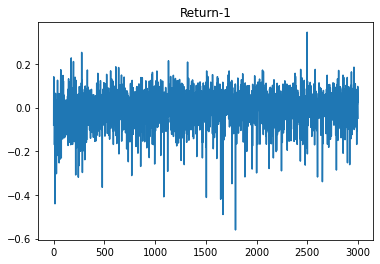

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

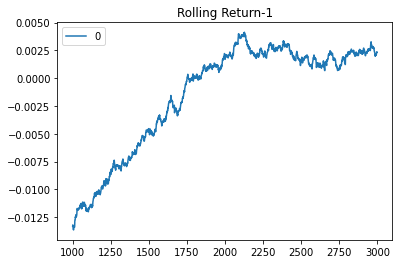

In [20]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

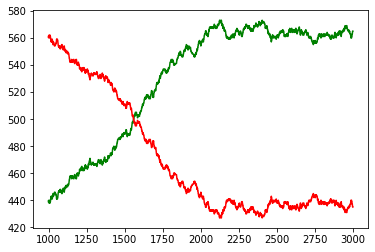

In [21]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

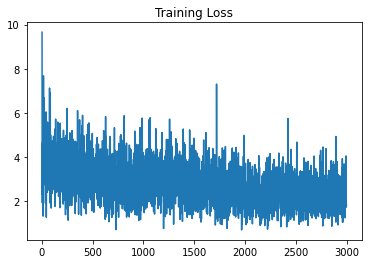

In [22]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

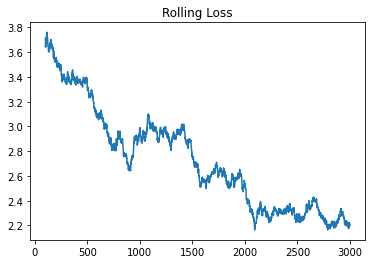

In [23]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

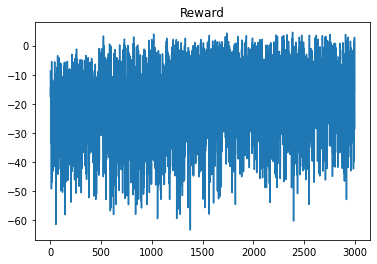

In [24]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

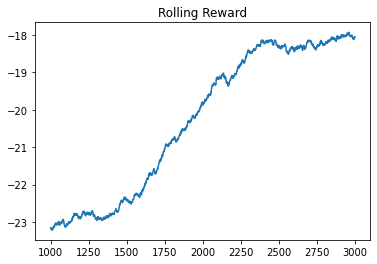

In [25]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

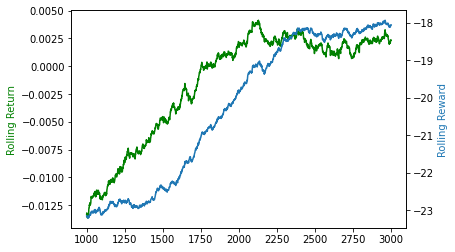

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

Run episode with trained model:

In [27]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

In [33]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        plt.ylim(min(plt_df.Open)*0.98, max(plt_df.Open)*1.02)
        
        start_date = (pd.to_datetime(plt_df.index[0]) - pd.to_timedelta(10,'d')).strftime('%Y-%m-%d')
        end_date = (pd.to_datetime(plt_df.index[-1]) + pd.to_timedelta(10,'d')).strftime('%Y-%m-%d')
        print(start_date)
        plt.plot(raw_data.loc[start_date:end_date].index,raw_data.loc[start_date:end_date].Open,color='black')
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.008*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.015*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Return: 1.061
Random return: 0.903
2010-12-24


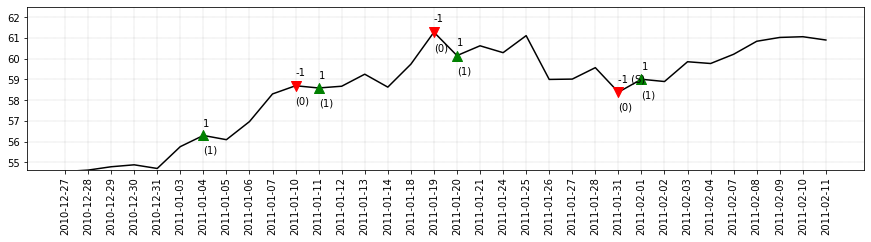

Return: 1.158
Random return: 0.853
2009-04-10


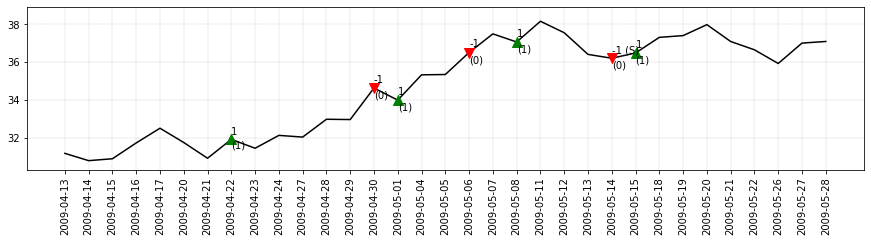

Return: 1.025
Random return: 0.961
2016-12-09


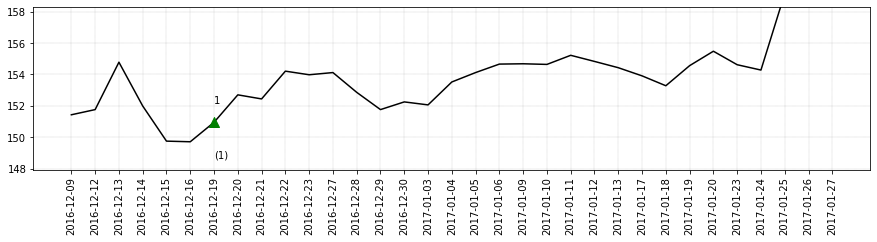

Return: 1.092
Random return: 0.955
2017-05-21


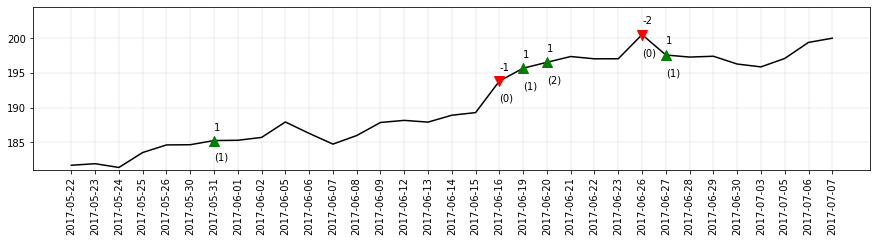

Return: 1.048
Random return: 0.925
2010-09-19


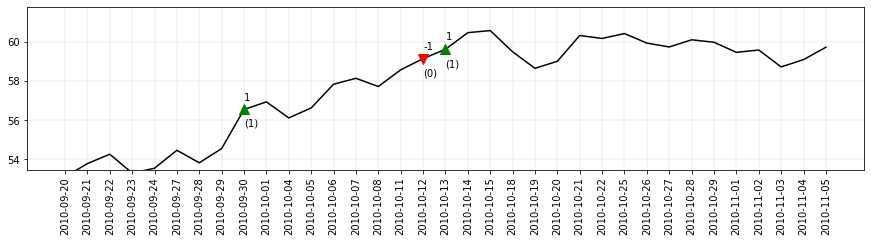

Return: 1.031
Random return: 1.027
2014-07-18


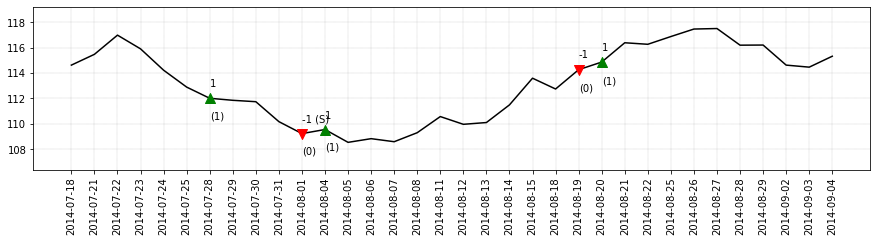

Return: 1.033
Random return: 0.935
2017-08-15


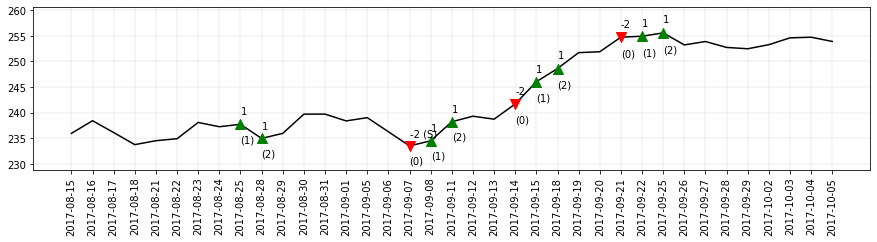

Return: 1.082
Random return: 0.876
2014-01-26


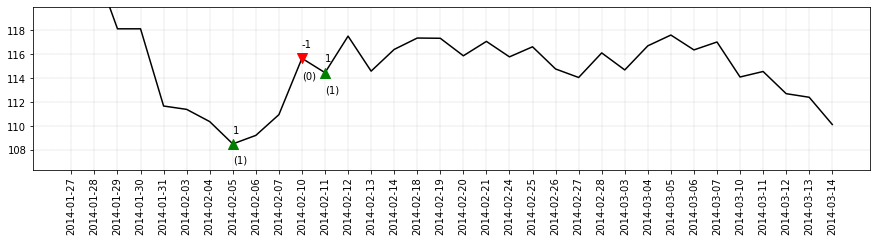

Return: 1.063
Random return: 0.940
2016-09-10


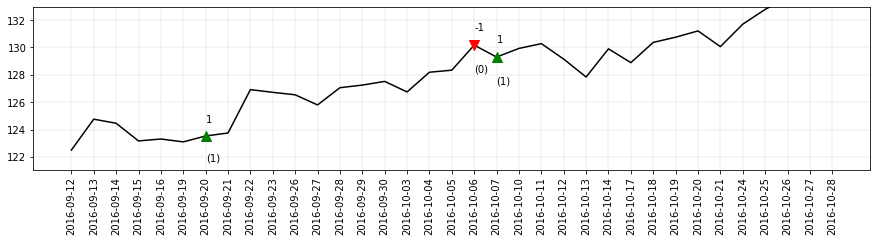

Return: 1.045
Random return: 0.948
2017-01-02


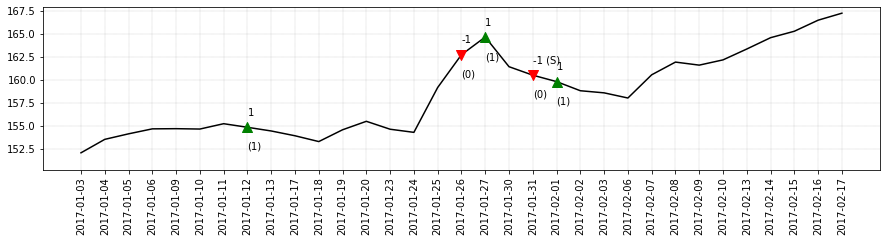

Return: 1.071
Random return: 0.973
2013-06-21


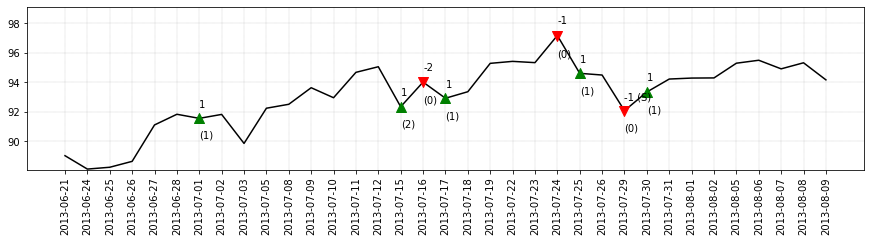

Return: 1.016
Random return: 0.749
2009-06-13


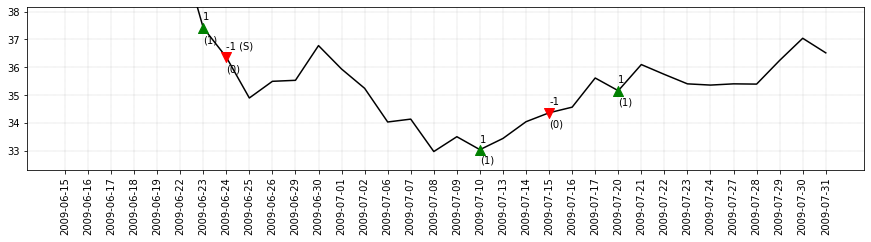

Return: 1.097
Random return: 1.056
2015-01-10


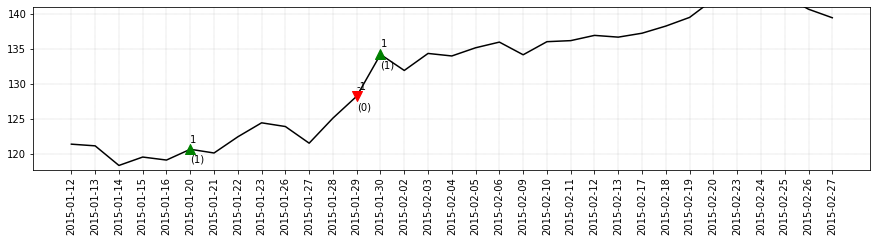

Return: 1.089
Random return: 0.961
2015-09-25


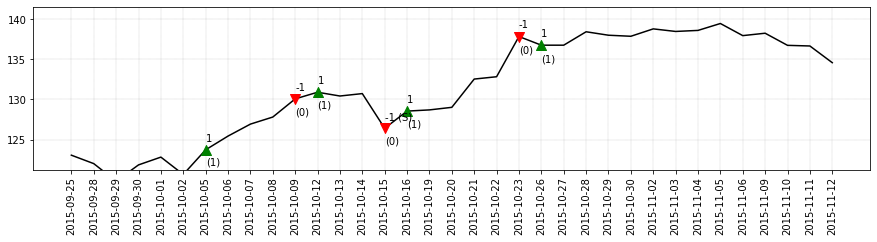

Return: 1.007
Random return: 0.989
2017-09-17


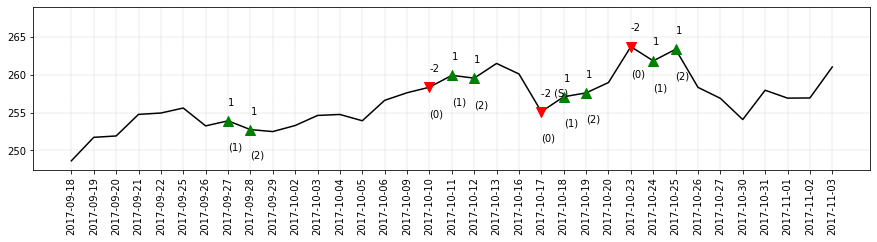

Return: 1.063
Random return: 0.958
2013-04-28


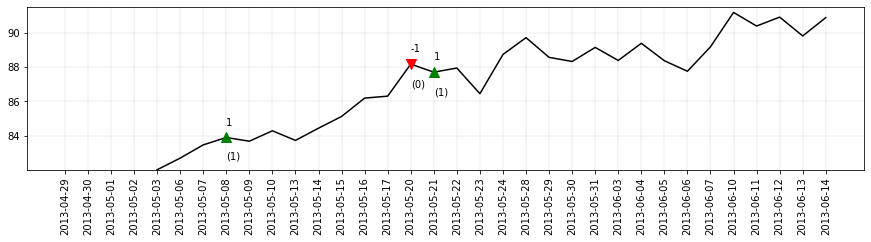

Return: 1.005
Random return: 1.001
2014-04-12


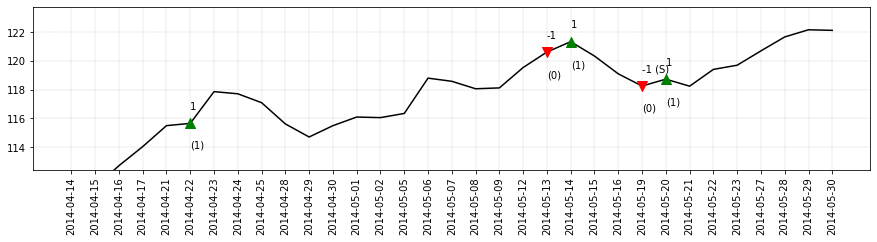

Return: 1.057
Random return: 0.905
2016-11-05


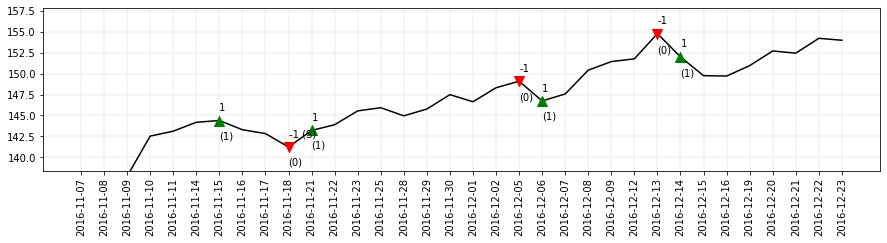

Return: 1.011
Random return: 0.931
2016-01-25


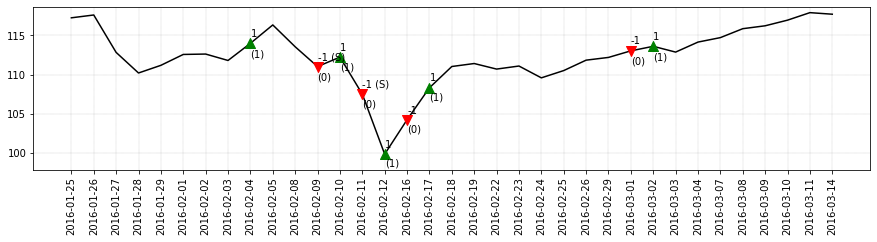

Return: 1.024
Random return: 1.022
2011-02-28


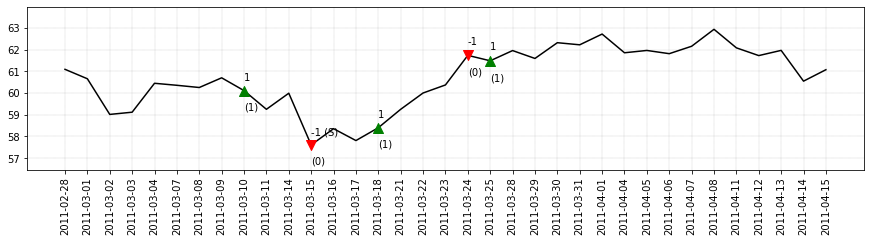

Return: 1.072
Random return: 1.018
2009-11-03


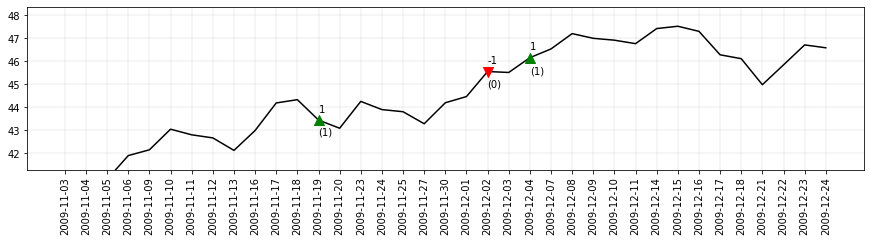

Return: 1.091
Random return: 0.924
2013-02-15


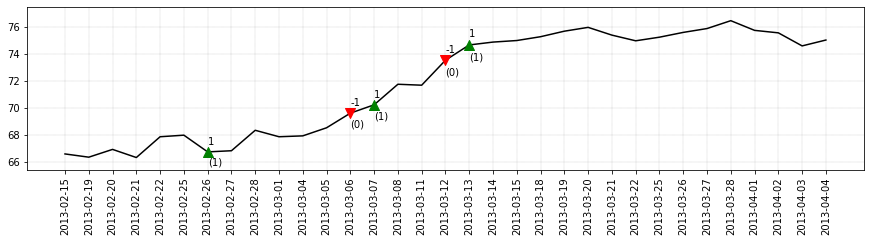

Return: 1.109
Random return: 0.913
2013-02-17


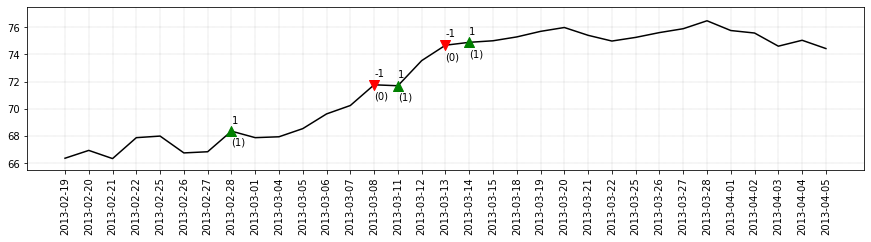

Return: 1.030
Random return: 1.042
2016-04-05


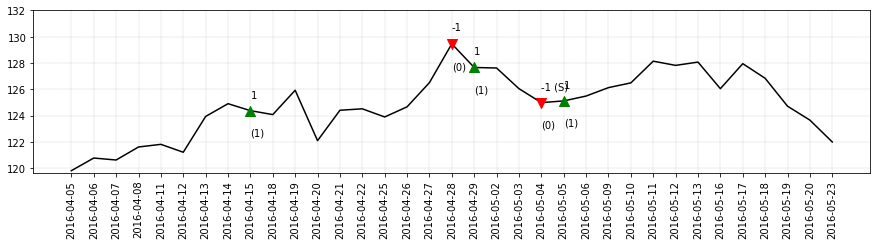

Return: 1.026
Random return: 0.886
2013-11-19


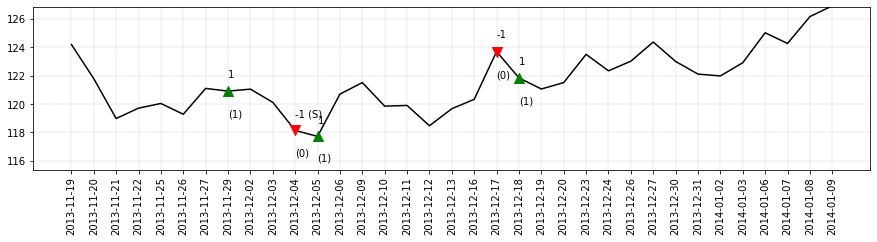

Return: 1.047
Random return: 1.530
2008-11-10


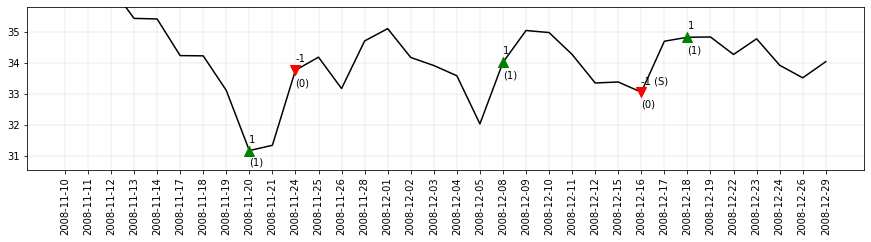

Return: 1.051
Random return: 1.256
2008-01-13


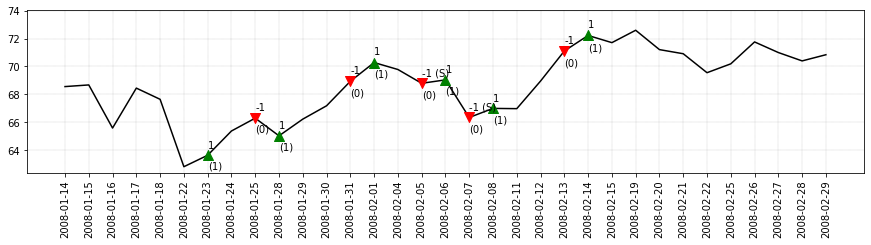

In [34]:
episode_count = 50

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [30]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (50 episodes): 1.009
Average random return (50 episodes): 0.978


In [31]:
prices

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1970-03-10,0.6153,0.6236,0.5988,0.6236,659401,0
1970-03-11,0.6323,0.6492,0.6323,0.6323,1019734,0
1970-03-12,0.6323,0.6323,0.6236,0.6236,749484,0
1970-03-13,0.6236,0.6323,0.6069,0.6153,706242,0
1970-03-16,0.6153,0.6153,0.5988,0.6069,817949,0
